In [29]:
using LowRankModels, DataFrames, Gadfly, Plotly
include("proxgrad.jl");

training = readtable("train.csv")
training[:Month] = DateTime(training[:Month],"yyyy-mm-ddTHH:MM:SS")
testing = readtable("test.csv")
testing[:Month] = DateTime(testing[:Month],"yyyy-mm-ddTHH:MM:SS")
DBurglary = training[training[:Text_General_Code].=="Burglary",:];

In [30]:
nVal = nrow(DBurglary)
nVal08 = Int(ceil(0.8*nVal))
randVals = randperm(nVal)
DBurglaryChanged = DBurglary[randVals, :];

In [31]:
DBurgtrain = DBurglaryChanged[1:nVal08, :]
DBurgtest = DBurglaryChanged[(nVal08+1):nVal, :];

## Models 1-4: Changing Input Space

In [32]:
n = nrow(DBurgtrain)
X₁ = [ones(n) DBurgtrain[:Temperature_Avg].data]
y₁ = DBurgtrain[:x1].data
w₁ = X₁\y₁

year_later = DBurgtrain[:x1][13:end]
year_before = DBurgtrain[:x1][1:(end-12)]
n₂ = size(year_later)
X₂ = [ones(n₂) DBurgtrain[:Temperature_Avg].data[13:end] year_before.data]
y₂ = year_later.data
w₂ = X₂\y₂ #Technically Can Delete...

X₃= [ones(n) DBurgtrain[:Temperature_Avg].data DBurgtrain[:Unemployment].data DBurgtrain[:Days_good_air_quality].data]
y₃ = DBurgtrain[:x1].data
w₃ = X₃\y₃

p = (DBurgtrain[:, 4:end])
p2 = Array([p[:, 1:8] p[:, 34:end]]) # excludes boolean values for the different crimes
X₄= [ones(n) p2]
y₄ = DBurgtrain[:x1].data
w₄ = X₄\y₄

Dmodels1 = DBurgtrain[:,3:3]
Dmodels2 = DBurgtrain[:,1:1]
Dmodels = [Dmodels2 Dmodels1]
Dmodels[:m1] =  X₁*w₁
Dmodels[:m2] =  vcat(Dmodels[:m1][1:12],X₂*w₂)
Dmodels[:m3] =  X₃*w₃
Dmodels[:m4] =  X₄*w₄;

## Models with different Loss Functions using Proximal Gradient

In [33]:
xL = svd(X₄)[2][1]
L = 1/(2*xL^2)
X₄ = convert(Array{Float64, 2},X₄)
w4QuadLoss = proxgrad_linesearch(QuadLoss(), ZeroReg(), X₄, y₄; stepsize = L, maxiters = 100000)
w4L1Loss = proxgrad_linesearch(L1Loss(), ZeroReg(), X₄, y₄; stepsize = L, maxiters = 1000000)
w4HuberLoss = proxgrad_linesearch(HuberLoss(), ZeroReg(), X₄, y₄; stepsize = L, maxiters = 1000000)
Dmodels[:m4QuadLoss] =  X₄*w4QuadLoss
Dmodels[:m4L1Loss] =  X₄*w4L1Loss
Dmodels[:m4HuberLoss] =  X₄*w4HuberLoss;

## Models with different Regularizers using Proximal Gradient and Quad Loss

In [34]:
w4QuadLossQuadReg = proxgrad_linesearch(QuadLoss(), QuadReg(1), X₄, y₄; stepsize = L, maxiters = 100000)
w4QuadLossOneReg = proxgrad_linesearch(QuadLoss(), OneReg(1), X₄, y₄; stepsize = L, maxiters = 100000)
Dmodels[:m4QuadLossQuadReg] =  X₄*w4QuadLossQuadReg
Dmodels[:m4QuadLossOneReg] =  X₄*w4QuadLossOneReg;

## MSE

In [35]:
mse(y,X,w) = mean((y-X*w).^2)
@show mse(y₄,1, Dmodels[:m1])
@show mse(y₄,1, Dmodels[:m2])
@show mse(y₄,1, Dmodels[:m3])
@show mse(y₄,1, Dmodels[:m4])
@show mse(y₄,1, Dmodels[:m4QuadLoss])
@show mse(y₄,1, Dmodels[:m4L1Loss])
@show mse(y₄,1, Dmodels[:m4HuberLoss])
@show mse(y₄,1, Dmodels[:m4QuadLossQuadReg])
@show mse(y₄,1, Dmodels[:m4QuadLossOneReg]);

mse(y₄,1,Dmodels[:m1]) = 15341.27408207777
mse(y₄,1,Dmodels[:m2]) = 14801.148606877892
mse(y₄,1,Dmodels[:m3]) = 12660.006488423827
mse(y₄,1,Dmodels[:m4]) = 5010.643402542374
mse(y₄,1,Dmodels[:m4QuadLoss]) = 12089.956505049067
mse(y₄,1,Dmodels[:m4L1Loss]) = 20257.889474190546
mse(y₄,1,Dmodels[:m4HuberLoss]) = 17515.143123267757
mse(y₄,1,Dmodels[:m4QuadLossQuadReg]) = 12090.06758832065
mse(y₄,1,Dmodels[:m4QuadLossOneReg]) = 12090.020652460678


# Now Lets Validate our models (Not Test yet)

In [36]:
Dmodels1 = DBurgtest[:,3:3]
Dmodels2 = DBurgtest[:,1:1]
DmodelsBurgTestC = [Dmodels2 Dmodels1]
nTestC = nrow(DBurgtest)
p = (DBurgtest[:, 4:end])
p2 = Array([p[:, 1:8] p[:, 34:end]]) # excludes boolean values for the different crimes
XtestC= [ones(nTestC) p2];
w₁

2-element Array{Float64,1}:
 728.412  
   4.00542

In [45]:
n = nrow(DBurgtest)
X₁TestV = [ones(n) DBurgtest[:Temperature_Avg].data]
X₃TestV= [ones(n) DBurgtest[:Temperature_Avg].data DBurgtest[:Unemployment].data DBurgtest[:Days_good_air_quality].data]
y₄ = DBurgtest[:x1].data
DmodelsBurgTestC[:m1] =   X₁TestV*w₁
DmodelsBurgTestC[:m3] =   X₃TestV*w₃
DmodelsBurgTestC[:m4] =   XtestC*w₄
DmodelsBurgTestC[:m4QuadLoss] =  XtestC*w4QuadLoss
DmodelsBurgTestC[:m4L1Loss] =  XtestC*w4L1Loss
DmodelsBurgTestC[:m4HuberLoss] =  XtestC*w4HuberLoss
DmodelsBurgTestC[:m4QuadLossQuadReg] =  XtestC*w4QuadLossQuadReg
DmodelsBurgTestC[:m4QuadLossOneReg] =  XtestC*w4QuadLossOneReg;


In [46]:
@show mse(y₄,1, DmodelsBurgTestC[:m1])
@show mse(y₄,1, DmodelsBurgTestC[:m3])
@show mse(y₄,1, DmodelsBurgTestC[:m4])
@show mse(y₄,1, DmodelsBurgTestC[:m4QuadLoss])
@show mse(y₄,1, DmodelsBurgTestC[:m4L1Loss])
@show mse(y₄,1, DmodelsBurgTestC[:m4HuberLoss])
@show mse(y₄,1, DmodelsBurgTestC[:m4QuadLossQuadReg])
@show mse(y₄,1, DmodelsBurgTestC[:m4QuadLossOneReg]);

mse(y₄,1,DmodelsBurgTestC[:m1]) = 10843.295066632305
mse(y₄,1,DmodelsBurgTestC[:m3]) = 7875.140783389742
mse(y₄,1,DmodelsBurgTestC[:m4]) = 8789.777694152055
mse(y₄,1,DmodelsBurgTestC[:m4QuadLoss]) = 7889.76623283564
mse(y₄,1,DmodelsBurgTestC[:m4L1Loss]) = 15982.307230366281
mse(y₄,1,DmodelsBurgTestC[:m4HuberLoss]) = 13360.183708130686
mse(y₄,1,DmodelsBurgTestC[:m4QuadLossQuadReg]) = 7889.785132619632
mse(y₄,1,DmodelsBurgTestC[:m4QuadLossOneReg]) = 7889.776249046635


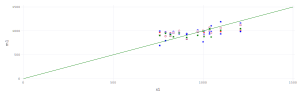

In [47]:
Gadfly.plot(DmodelsBurgTestC,x=:x1,y=:m1, Geom.point, Theme(default_color=colorant"green"),
layer(x=collect(1:1500),y=collect(1:1500),Geom.line),
layer(x=:x1,y=:m3,Geom.point, Theme(default_color=colorant"pink")),
layer(x=:x1,y=:m4,Geom.point, Theme(default_color=colorant"blue")),
layer(x=:x1,y=:m4QuadLoss,Geom.point, Theme(default_color=colorant"purple")),
layer(x=:x1,y=:m4L1Loss,Geom.point, Theme(default_color=colorant"blue")),
layer(x=:x1,y=:m4HuberLoss,Geom.point, Theme(default_color=colorant"red")),
layer(x=:x1,y=:m4QuadLossQuadReg,Geom.point, Theme(default_color=colorant"brown")),
layer(x=:x1,y=:m4QuadLossOneReg,Geom.point, Theme(default_color=colorant"orange")),)

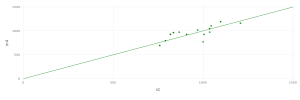

In [48]:
Gadfly.plot(DmodelsBurgTestC,x=:x1,y=:m4, Geom.point, Theme(default_color=colorant"green"),
layer(x=collect(1:1500),y=collect(1:1500),Geom.line))

### This shows that QR factorization is the best model to fit the data...but that isn't true

# Testing the models

In [49]:
# MUST REDO
Dtest = testing[testing[:Text_General_Code].=="Burglary",:]
Dmodels1 = Dtest[:,3:3]
Dmodels2 = Dtest[:,1:1]
DmodelsTest = [Dmodels2 Dmodels1]
n = nrow(Dtest)
p = (Dtest[:, 4:end])
p2 = Array([p[:, 1:8] p[:, 34:end]]) # excludes boolean values for the different crimes
Xtest= [ones(n) p2]

X₁Test = [ones(n) Dtest[:Temperature_Avg].data]
X₃Test= [ones(n) Dtest[:Temperature_Avg].data Dtest[:Unemployment].data Dtest[:Days_good_air_quality].data]
y₄ = Dtest[:x1].data

DmodelsTest[:m1] =   X₁Test*w₁
DmodelsTest[:m3] =   X₃Test*w₃
DmodelsTest[:m4] =   Xtest*w₄
DmodelsTest[:m4QuadLoss] =  Xtest*w4QuadLoss
DmodelsTest[:m4L1Loss] =  Xtest*w4L1Loss
DmodelsTest[:m4HuberLoss] =  Xtest*w4HuberLoss
DmodelsTest[:m4QuadLossQuadReg] =  Xtest*w4QuadLossQuadReg
DmodelsTest[:m4QuadLossOneReg] =  Xtest*w4QuadLossOneReg;

In [42]:
@show mse(y₄,1, DmodelsTest[:m1])
@show mse(y₄,1, DmodelsTest[:m3])
@show mse(y₄,1, DmodelsTest[:m4])
@show mse(y₄,1, DmodelsTest[:m4QuadLoss])
@show mse(y₄,1, DmodelsTest[:m4L1Loss])
@show mse(y₄,1, DmodelsTest[:m4HuberLoss])
@show mse(y₄,1, DmodelsTest[:m4QuadLossQuadReg])
@show mse(y₄,1, DmodelsTest[:m4QuadLossOneReg]);

mse(y₄,1,DmodelsTest[:m1]) = 12203.342885460004
mse(y₄,1,DmodelsTest[:m3]) = 14762.55888227988
mse(y₄,1,DmodelsTest[:m4]) = 462782.288448815
mse(y₄,1,DmodelsTest[:m4QuadLoss]) = 11511.866566941913
mse(y₄,1,DmodelsTest[:m4L1Loss]) = 18471.8572340407
mse(y₄,1,DmodelsTest[:m4HuberLoss]) = 12438.652435703794
mse(y₄,1,DmodelsTest[:m4QuadLossQuadReg]) = 11511.746561651356
mse(y₄,1,DmodelsTest[:m4QuadLossOneReg]) = 11511.846249737791


In [43]:
set_default_plot_size(30cm,10cm)
Gadfly.plot(DmodelsTest,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m1,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:m3,Geom.line,Theme(default_color=colorant"blue")),
layer(x=:Month,y=:m4,Geom.line,Theme(default_color=colorant"red")),
layer(x=:Month,y=:m4QuadLoss,Geom.line,Theme(default_color=colorant"purple")),
layer(x=:Month,y=:m4L1Loss,Geom.line,Theme(default_color=colorant"green")),
layer(x=:Month,y=:m4HuberLoss,Geom.line,Theme(default_color=colorant"yellow")),
layer(x=:Month,y=:m4QuadLossQuadReg,Geom.line,Theme(default_color=colorant"brown")),
layer(x=:Month,y=:m4QuadLossOneReg,Geom.line,Theme(default_color=colorant"black")),
#REDO THE LEGENDt
Guide.manual_color_key("Legend", ["QuadLoss", "HuberLoss", "Huber&QuadReg", "Huber&QuadConst", "Huber&l1Reg"], ["orange", "blue", "red", "purple", "green"]))